# **STMO Project**
### Dilara Ağacik, Robbe Fonteyn, Kaan Turker

## Load in Libraries

In [114]:
import os
import osmnx as ox
import networkx as nx
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from ipywidgets import interact, IntSlider
from itertools import permutations
from random import choice, random
import random

## Setup graph

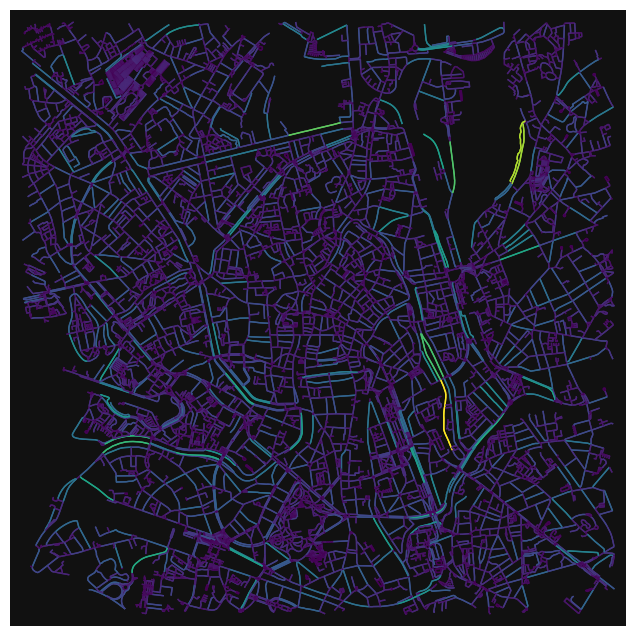

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [149]:
file_path = "data/graph.graphml"
geolocator = Nominatim(user_agent="STMO_project", timeout=10)

if not os.path.exists(file_path):

    # Define the address as a starting point
    center = "Cataloniëstraat 4, 9000 Gent"

    # Geocode the address to get its latitude and longitude
    center_point = ox.geocode(center)

    # Define the buffer distance (in meters) for the map area
    buffer_distance = 2500  # Meters radius from center point

    # Download the street network data within the buffer distance around the center point
    graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')
    graph = ox.distance.add_edge_lengths(graph)

    # Save the current plot
    ox.io.save_graphml(graph)

else:
    graph = ox.io.load_graphml(file_path)

# Plot the graph to verify
ec = ox.plot.get_edge_colors_by_attr(graph, attr='length')
ox.plot_graph(graph, edge_color=ec, node_alpha=0)

In [ ]:
city_nodes, city_edges = ox.graph_to_gdfs(graph)
city_nodes

In [ ]:
print(city_edges)

In [12]:
def translate_address(graph, geolocator, address: str, return_coords=False):
    """
    Translate an address to a corresponding node in the specified graph.
    """

    # Geocode the address to get latitude and longitude
    location = geolocator.geocode(address)
    if location is None:
        raise ValueError(f"Address '{address}' could not be geocoded.")

    start_lat, start_lon = location.latitude, location.longitude

    # Find the nearest node in the graph
    node = ox.distance.nearest_nodes(graph, X=start_lon, Y=start_lat)
    if node is None:
        raise ValueError("No nearest node found in the graph for the given address.")

    if return_coords:
        return node, (start_lon, start_lat)
    else:
        return node


## Default implementation to learn how to use packages

In [ ]:
# Define a start address:
start_address = "Eugene-felixdreef 1, ghent Belgium"

start_node = translate_address(graph, geolocator, start_address, False)

# Run Dijkstra's algorithm to get the shortest paths from the start node
distances, predecessors = nx.single_source_dijkstra(graph, source=start_node, weight='length')  # 'length' is the edge attribute for distance

# Set target distance (5 km)
target_distance = 2000  # in meters
threshold = 50  # in meters (± 50 meters)

# Filter nodes that are within the threshold distance
close_nodes = {node: distance for node, distance in distances.items() if abs(distance - target_distance) <= threshold}
print("Number of possible nodes", len(close_nodes))

# Select a target node, the one that is about 5 km away (choose any from close_nodes)
target_node = list(close_nodes.keys())[0]  # Select the first node (or choose based on your preference)

# Get the specific route between start_node and target_node
route = nx.shortest_path(graph, source=start_node, target=target_node, weight='length')

# Visualize the route on the map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the full graph
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)
# Plot the specific route
ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='white', ax=ax, show=True)


## Setting up points of interest

These points of interest will be used as an input to all of the algorithms, they are common tourist spots in Ghent.

In [68]:
# Points of interest
addresses = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Museum of Industry": "Minnemeers 10, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium",
    "St. Bavo's Cathedral": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Ghent University Botanical Garden": "Karel Lodewijk Ledeganckstraat 35, 9000 Gent, Belgium",
    "STAM Ghent City Museum": "Godshuizenlaan 2, 9000 Gent, Belgium",
    "Design Museum Gent": "Jan Breydelstraat 5, 9000 Gent, Belgium",
    "Citadelpark": "Citadelpark, 9000 Gent, Belgium",
    "Korenmarkt": "Korenmarkt, 9000 Gent, Belgium",
    "The House of Alijn": "Kraanlei 65, 9000 Gent, Belgium",
    "SMAK Museum of Contemporary Art": "Jan Hoetplein 1, 9000 Gent, Belgium"
}

predefined_coords = {
    "Gravensteen": (51.056279, 3.720084),
    "Museum of Industry": (51.063314, 3.728368),
    "Sint Rita": (51.047553, 3.717246),
    "Lievekaai": (51.056810, 3.721897),
    "St. Bavo's Cathedral": (51.053541, 3.725765),
    "Ghent University Botanical Garden": (51.030263, 3.710734),
    "STAM Ghent City Museum": (51.046202, 3.721773),
    "Design Museum Gent": (51.054369, 3.718559),
    "Citadelpark": (51.036299, 3.718643),
    "Korenmarkt": (51.053949, 3.720967),
    "The House of Alijn": (51.056587, 3.721885),
    "SMAK Museum of Contemporary Art": (51.037662, 3.710559)
}


## Genetic Algorithm Implementation

In [15]:
# Fitness Function
# The fitness function evaluates how close the total length of a path is to the target distance
def fitness(graph, path, target_distance):
    path_length = sum(
        nx.shortest_path_length(graph, path[i], path[i + 1], weight='length')
        for i in range(len(path) - 1)
    )
    # Penalize paths that exceed the target distance
    return -abs(target_distance - path_length) - (0.1 * max(0, path_length - target_distance))


In [16]:
# Crossover
# Combine two parent paths to create an offspring path
def crossover(parent1, parent2):
    split_idx = random.randint(1, len(parent1) - 2)
    child = parent1[:split_idx] + [node for node in parent2 if node not in parent1[:split_idx]]
    return child

In [17]:
# Mutation
# Introduce small changes to paths
def mutate(path):
    idx1, idx2 = random.sample(range(1, len(path) - 1), 2)  # Avoid start node
    path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

In [18]:
# Initialize Population
# Generate random paths:
def initialize_population(nodes, population_size):
    population = []
    for _ in range(population_size):
        path = nodes[1:]  # Exclude the start node
        random.shuffle(path)
        path = [nodes[0]] + path  # Add start node back
        population.append(path)
    return population

In [81]:
def genetic_algorithm(graph, nodes, start_node, target_distance, mutation_rate=0.1, allow_vertex_reuse=False, population_size=100, generations=200, early_stopping_rounds=10, verbose=0):
    nodes = list(start_node.values()) + list(nodes.values())  # Include start node
    population = initialize_population(nodes, population_size)
    history = []  # To store the best path of each generation
    best_lengths = []  # To store the best lengths of each generation
    best_path = None
    best_length = float('inf')
    no_improvement_rounds = 0  # Counter for early stopping

    for generation in range(generations):
        # Evaluate fitness
        population_fitness = []
        for path in population:
            # Enforce the no-reuse constraint if needed
            if not allow_vertex_reuse and len(set(path)) != len(path):
                fitness_value = float('-inf')  # Penalize paths that reuse vertices
            else:
                fitness_value = fitness(graph, path, target_distance)
            population_fitness.append((path, fitness_value))

        # Sort by fitness descending
        population_fitness.sort(key=lambda x: x[1], reverse=True)

        # Save the best path of this generation
        current_best_path, _ = population_fitness[0]
        history.append(current_best_path)

        # Calculate the best length of this generation
        current_length = sum(
            nx.shortest_path_length(graph, current_best_path[i], current_best_path[i + 1], weight='length')
            for i in range(len(current_best_path) - 1)
        )
        best_lengths.append(current_length)

        # Update the best path and length if current path is better
        if abs(target_distance - current_length) < abs(target_distance - best_length):
            best_path = current_best_path
            best_length = current_length
            no_improvement_rounds = 0  # Reset early stopping counter
        else:
            no_improvement_rounds += 1

        # Check for early stopping
        if no_improvement_rounds >= early_stopping_rounds:
            print(f"Early stopping at generation {generation} due to no improvement in last {early_stopping_rounds} generations.")
            break
        
        if verbose == 1:
            print(f"Generation: [{generation+1}/{generations}] --- Best path: {population_fitness[0][0]} with length: {best_length}")
        else:
            print(f"Generation: [{generation+1}/{generations}] --- Best length: {best_length}")

        # Select parents
        parents = [path for path, _ in population_fitness[:population_size // 2]]

        # Generate next generation
        next_generation = parents[:]
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:  # Mutation probability
                child = mutate(child)
            next_generation.append(child)

        population = next_generation

    return best_path, best_length, history, best_lengths


In [ ]:
nodes_to_visit = dict()

for monument in addresses.keys():
    current = addresses[monument]
    nodes_to_visit[monument] = translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

In [70]:
nodes_to_visit = {name: ox.distance.nearest_nodes(graph, coord[1], coord[0]) for name, coord in predefined_coords.items()}

In [82]:
# Define the graph and nodes
start_address = "Eugene-felixdreef 1, ghent Belgium"
start_node = {start_address: translate_address(graph, geolocator, start_address, False)}


# Run GA
target_distance = 15000  # Target distance in meters
best_path, best_length, history, best_lengths = genetic_algorithm(
    graph = graph, 
    nodes = nodes_to_visit, 
    start_node = start_node, 
    target_distance = target_distance, 
    generations = 100, population_size=100, 
    mutation_rate=0.5, early_stopping_rounds=15,
    allow_vertex_reuse=False
)

print("Best Path:", best_path)
print("Path Length:", best_length)

Generation: [1/100] --- Best length: 14983.197269669574
Generation: [2/100] --- Best length: 14983.197269669574
Generation: [3/100] --- Best length: 14983.197269669574
Generation: [4/100] --- Best length: 14984.875391775393
Generation: [5/100] --- Best length: 15001.370015532812
Generation: [6/100] --- Best length: 15001.370015532812
Generation: [7/100] --- Best length: 15001.370015532812
Generation: [8/100] --- Best length: 15001.370015532812
Generation: [9/100] --- Best length: 15001.370015532812
Generation: [10/100] --- Best length: 15001.370015532812
Generation: [11/100] --- Best length: 15000.860056178848
Generation: [12/100] --- Best length: 15000.860056178848
Generation: [13/100] --- Best length: 15000.860056178848
Generation: [14/100] --- Best length: 15000.860056178848
Generation: [15/100] --- Best length: 15000.860056178848
Generation: [16/100] --- Best length: 15000.860056178848
Generation: [17/100] --- Best length: 15000.860056178848
Generation: [18/100] --- Best length: 15

In [93]:
def plot_path_GA(graph, path, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the base graph
    ox.plot_graph(graph, ax=ax, show=False, close=False, bgcolor='white', edge_color='black', node_color='white', node_size=1, edge_linewidth=0.5)

    # Gather all edges for the path
    edges = []
    for i in range(len(path) - 1):
        route = nx.shortest_path(graph, path[i], path[i + 1], weight='length')
        edges += list(zip(route[:-1], route[1:]))
    
    # Get node coordinates for plotting
    node_positions = {node: (graph.nodes[node]['x'], graph.nodes[node]['y']) for node in graph.nodes}
    edge_positions = [(node_positions[edge[0]], node_positions[edge[1]]) for edge in edges]

    # Plot the path edges
    for start, end in edge_positions:
        ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2, zorder=3)

    # Highlight the nodes in the path
    path_coords = [node_positions[node] for node in path]
    path_x, path_y = zip(*path_coords)
    ax.scatter(path_x, path_y, color='blue', s=50, zorder=4)

    # Annotate nodes
    for idx, (x, y) in enumerate(path_coords):
        ax.text(x, y, str(idx), fontsize=6, ha='center', va='center', color='black', zorder=5)

    ax.set_title("Path Visualization on Graph")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


In [94]:
def visualize_GA(graph, history, best_lengths, target_distance):
    @interact(generation=IntSlider(min=0, max=len(history)-1, step=1, value=len(history)-1))
    def show_generation(generation):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Plot the graph and path for the selected generation
        plot_path_GA(graph, history[generation], ax=ax1)
        ax1.set_title(f"Generation: {generation}, Best Length: {best_lengths[generation]:.2f}")

        # Plot the best lengths up to the current generation
        ax2.plot(range(1, len(best_lengths) + 1), best_lengths, linestyle='-', color='blue', label='Best Lengths')
        ax2.scatter(generation + 1, best_lengths[generation], color='red', s=100, zorder=3, label='Selected Generation')
        ax2.axvline(x=generation + 1, color='red', linestyle='--', linewidth=1)
        ax2.axhline(y=target_distance, color='green', linestyle='--', linewidth=2, label='Target Distance')

        # Dynamically set y-axis limits to include target_distance and best_lengths
        min_y = min(min(best_lengths), target_distance) * 0.95
        max_y = max(max(best_lengths), target_distance) * 1.05
        ax2.set_ylim(min_y, max_y)

        # Customize the plot
        ax2.set_xlim(1, len(best_lengths))
        ax2.set_title("Best Path Lengths Across Generations")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Best Path Length")
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.show()


In [80]:
visualize_GA(graph, history, best_lengths, target_distance)

interactive(children=(IntSlider(value=99, description='generation', max=99), Output()), _dom_classes=('widget-…

### Random points of interest in the graph

In [57]:
def generate_random_node(graph, num_nodes=10):
    # Get a list of all nodes in the graph
    all_nodes = list(graph.nodes)
    
    # Randomly sample the desired number of nodes
    random_nodes = random.sample(all_nodes, num_nodes)
    
    # Create a dictionary with descriptive keys
    random_nodes_dict = {f"Node {i+1}": node for i, node in enumerate(random_nodes)}
    
    return random_nodes_dict

random_nodes = generate_random_node(graph, num_nodes=10)
print("Randomly selected nodes:", random_nodes)

Randomly selected nodes: {'Node 1': 3769532271, 'Node 2': 8669039266, 'Node 3': 1170919117, 'Node 4': 5429247450, 'Node 5': 4557196080, 'Node 6': 498134927, 'Node 7': 10962332403, 'Node 8': 2232228301, 'Node 9': 11070982807, 'Node 10': 245090868}


In [ ]:
# Define the graph and nodes
start_node = generate_random_node(graph, num_nodes=1)

# Run GA
target_distance = 15000  # Target distance in meters
best_path, best_length, history, best_lengths = genetic_algorithm(
    graph = graph, 
    nodes = random_nodes, 
    start_node = start_node, 
    target_distance = target_distance, 
    generations = 100, population_size=100, 
    mutation_rate=0.5, early_stopping_rounds=25,
    allow_vertex_reuse=False
)

print("Best Path:", best_path)
print("Path Length:", best_length)

In [ ]:
visualize_GA(graph, history, best_lengths, target_distance=target_distance)

# Simulated Annealing

In [36]:
def calculate_route_distance(graph, route):
    """Calculate the total distance of a route."""
    distance = 0
    for i in range(len(route) - 1):
        try:
            distance += nx.shortest_path_length(graph, source=route[i], target=route[i + 1], weight='length')
        except nx.NetworkXNoPath:
            distance += float('inf')  # Penalize routes with no valid path
    return distance

In [116]:
def simulated_annealing(graph, poi_coords, start_node, max_iterations=1000, initial_temp=1000, cooling_rate=0.99):
    """
    Simulated Annealing to find an optimized route visiting all points of interest (POIs).

    Parameters:
    -----------
    graph : networkx.MultiDiGraph
        The road network graph.
    poi_coords : list
        List of POI nodes to visit.
    start_node : int
        The starting node in the graph.
    max_iterations : int
        Maximum number of iterations.
    initial_temp : float
        Starting temperature for the annealing process.
    cooling_rate : float
        Rate at which the temperature decreases.

    Returns:
    --------
    best_route : list
        Optimized route as a sequence of nodes.
    best_distance : float
        Distance of the best route.
    """
    # Initialize variables
    current_route = [start_node] + poi_coords + [start_node]  # Start and end at the same node
    best_route = current_route[:]
    best_distance = calculate_route_distance(graph, current_route)

    current_temp = initial_temp

    for iteration in range(max_iterations):
        # Create a new route by swapping two random POIs (excluding start/end nodes)
        new_route = current_route[:]
        i, j = np.random.choice(range(1, len(poi_coords) + 1), size=2, replace=False)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        # Calculate the distances of the current and new routes
        current_distance = calculate_route_distance(graph, current_route)
        new_distance = calculate_route_distance(graph, new_route)

        # Decide whether to accept the new route
        if new_distance < current_distance or random.random() < exp(-(new_distance - current_distance) / current_temp):
            current_route = new_route[:]

            # Update the best route if the new one is better
            if new_distance < best_distance:
                best_route = new_route[:]
                best_distance = new_distance

        # Cool down the temperature
        current_temp *= cooling_rate

        # Early stopping if temperature is too low
        if current_temp < 1e-3:
            break

    return best_route, best_distance

In [42]:
def build_valid_route(graph, route):
    """Ensure all consecutive nodes in the route are connected."""
    valid_route = []
    for i in range(len(route) - 1):
        try:
            # Find shortest path between two consecutive nodes
            sub_path = nx.shortest_path(graph, source=route[i], target=route[i + 1], weight='length')
            if valid_route:
                valid_route.extend(sub_path[1:])  # Avoid duplicating nodes
            else:
                valid_route.extend(sub_path)
        except nx.NetworkXNoPath:
            print(f"No path between {route[i]} and {route[i + 1]} in the graph.")
            return None  # Return None if any part of the route is invalid
    return valid_route

def validate_nodes(graph, route):
    """Check if all nodes in the route exist in the graph."""
    missing_nodes = [node for node in route if node not in graph.nodes]
    if missing_nodes:
        print(f"Missing nodes in graph: {missing_nodes}")
    else:
        print("All nodes in the route exist in the graph.")

def validate_edges(graph, route):
    """Check if edges exist between consecutive nodes in the route."""
    missing_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1) if not graph.has_edge(route[i], route[i + 1])]
    if missing_edges:
        print(f"Missing edges between consecutive nodes: {missing_edges}")
    else:
        print("All edges between consecutive nodes exist in the graph.")

In [47]:
# Define POIs
predefined_coords = {
    "Gravensteen": (51.056279, 3.720084),
    "Museum of Industry": (51.063314, 3.728368),
    "Sint Rita": (51.047553, 3.717246),
    "Lievekaai": (51.056810, 3.721897),
}
poi_coords = [
    ox.distance.nearest_nodes(graph, X=lon, Y=lat)
    for lat, lon in [
        predefined_coords["Gravensteen"],
        predefined_coords["Museum of Industry"],
        predefined_coords["Sint Rita"],
        predefined_coords["Lievekaai"]
    ]
]

# Starting node
start_address = "Eugene-felixdreef 1, ghent Belgium"
start_node = ox.distance.nearest_nodes(graph, X=3.722391, Y=51.038671)  # Replace with actual lat/lon of the start address

# Run Simulated Annealing
best_route, best_distance = simulated_annealing(
    graph, poi_coords, start_node, max_iterations=1000, initial_temp=1000, cooling_rate=0.99
)

# Print results
print("Best Route (Node IDs):", best_route)
print("Best Distance (meters):", best_distance)

Best Route (Node IDs): [8072295178, 440871168, 82775037, 1212148854, 247108130, 8072295178]
Best Distance (meters): 6759.206364102618


Validating nodes and edges in the best_route...
All nodes in the route exist in the graph.
Missing edges between consecutive nodes: [(8072295178, 440871168), (440871168, 82775037), (82775037, 1212148854), (1212148854, 247108130), (247108130, 8072295178)]
Valid route constructed successfully.
Valid Route (Node IDs): [8072295178, 1504862003, 3315008683, 6106437514, 256261277, 204735153, 256261039, 256261079, 3801970789, 1787465659, 1787465658, 245090880, 1802217541, 245090881, 41336291, 41336293, 245419768, 245419770, 48218045, 725563485, 245419784, 26268623, 246698848, 1804204247, 220580902, 203691129, 220580930, 2365899709, 3621190785, 11149109415, 38436755, 567194581, 576538811, 4789453032, 95813070, 2574777591, 513284890, 513284903, 220556322, 95813076, 249190809, 95813079, 457939321, 248070765, 4228111798, 1970580017, 220522391, 1128910253, 4408549451, 572577343, 1903121984, 719181388, 667071318, 283170781, 1552886871, 5225558073, 1581096504, 247880459, 1123860632, 599296056, 599296

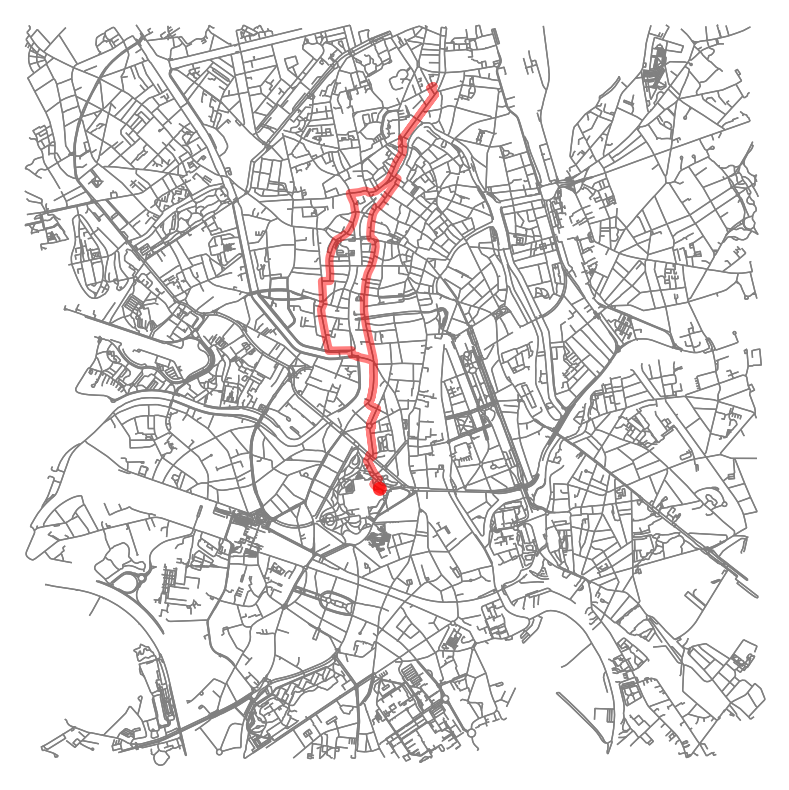

In [48]:
# Validate nodes and edges in the best_route
print("Validating nodes and edges in the best_route...")
validate_nodes(graph, best_route)
validate_edges(graph, best_route)

# Build a fully valid route
valid_route = build_valid_route(graph, best_route)

if valid_route:
    print("Valid route constructed successfully.")
    print("Valid Route (Node IDs):", valid_route)
else:
    print("The route contains unreachable nodes. Please verify the graph and node connections.")

# Visualize the valid route
if valid_route:
    fig, ax = plt.subplots(figsize=(10, 10))
    ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)
    ox.plot_graph_route(graph, valid_route, route_linewidth=6, node_size=0, bgcolor='white', ax=ax, show=True)

# Brute Force Implementation

In [49]:
# Brute Force Algorithm
def brute_force_algorithm(graph, nodes, start_node, target_distance, allow_vertex_reuse=False, threshold=50, verbose=0):
    """
    Run the brute force algorithm to find the optimal path.

    Parameters:
    ----------
    graph : networkx.Graph
        The graph representing the network.
    nodes : dict
        Dictionary of nodes to visit.
    start_node : int
        The starting node in the graph.
    target_distance : float
        The target distance for the path.
    allow_vertex_reuse : bool, optional
        Whether to allow reusing nodes in the path.
    threshold : float, optional
        The allowed deviation from the target distance.
    verbose : int, optional
        Verbosity level.

    Returns:
    -------
    tuple
        The best path, best length, history, and best lengths.
    """
    nodes = list(nodes.values())
    valid_permutations = []
    for perm in permutations(nodes):
        path = [start_node] + list(perm) + [start_node]
        if all(nx.has_path(graph, path[i], path[i + 1]) for i in range(len(path) - 1)):
            valid_permutations.append(perm)

    best_path, best_length = None, float('inf')
    history, best_lengths = [], []

    for generation, perm in enumerate(valid_permutations):
        path = [start_node] + list(perm) + [start_node]

        # Evaluate path length
        current_length = calculate_route_distance(graph, path)
        history.append((path, current_length))

        if abs(current_length - target_distance) <= threshold and current_length < best_length:
            best_path, best_length = path, current_length

        best_lengths.append(best_length)

        if verbose:
            print(f"Generation {generation}: Path {path} | Length = {current_length:.2f}")

    return best_path, best_length, history, best_lengths

In [96]:
def plot_path_BF(graph, path, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the base graph using OSMnx
    ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)

    # Highlight the best path
    edges = []
    for i in range(len(path) - 1):
        try:
            route = nx.shortest_path(graph, path[i], path[i + 1], weight='length')
            edges += list(zip(route[:-1], route[1:]))
        except nx.NetworkXNoPath:
            print(f"No path between {path[i]} and {path[i+1]}. Skipping this segment.")

    # Draw the red path between nodes
    edge_x = []
    edge_y = []
    for edge in edges:
        x = [graph.nodes[edge[0]]['x'], graph.nodes[edge[1]]['x']]
        y = [graph.nodes[edge[0]]['y'], graph.nodes[edge[1]]['y']]
        edge_x.extend(x + [None])  # Add None to break line segments
        edge_y.extend(y + [None])

    ax.plot(edge_x, edge_y, color='red', linewidth=2, label='Best Path')

    # Annotate nodes
    for idx, node in enumerate(path):
        x, y = graph.nodes[node].get('x', 0), graph.nodes[node].get('y', 0)
        ax.scatter(x, y, color='blue', s=50, zorder=5)
        ax.text(x, y, str(idx), fontsize=8, color='black', ha='center', va='center', zorder=6)

    ax.set_title("Optimal Path Visualization")
    ax.legend()


In [95]:
# Visualization
def visualize_brute_force(graph, history, best_lengths, target_distance):
    """
    Visualize the progress of the brute force algorithm.

    Parameters:
    ----------
    graph : networkx.Graph
        The graph representing the network.
    history : list
        List of paths and their lengths for each iteration.
    best_lengths : list
        List of best lengths across iterations.
    target_distance : float
        The target distance for the path.
    """
    valid_best_lengths = [length for length in best_lengths if np.isfinite(length)]

    if not valid_best_lengths:
        print("No valid path lengths available to visualize.")
        return

    @interact(generation=IntSlider(min=0, max=len(history)-1, step=1, value=len(history)-1))
    def show_generation(generation):
        # Extract the path for the selected generation
        path, path_length = history[generation]

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Plot the graph and path for the selected generation
        plot_path_BF(graph, path, ax=ax1)
        ax1.set_title(f"Generation: {generation}, Path Length: {path_length:.2f}")

        # Plot the best lengths up to the current generation
        ax2.plot(range(1, len(valid_best_lengths) + 1), valid_best_lengths, linestyle='-', color='blue', label='Best Lengths')
        if generation < len(valid_best_lengths):
            ax2.scatter(generation + 1, valid_best_lengths[generation], color='red', s=100, zorder=3, label='Selected Generation')
        ax2.axvline(x=generation + 1, color='red', linestyle='--', linewidth=1)
        ax2.axhline(y=target_distance, color='green', linestyle='--', linewidth=2, label='Target Distance')

        # Dynamically set y-axis limits to include target_distance and best_lengths
        min_y = min(valid_best_lengths + [target_distance]) * 0.95
        max_y = max(valid_best_lengths + [target_distance]) * 1.05
        ax2.set_ylim(min_y, max_y)

        # Customize the plot
        ax2.set_xlim(1, len(valid_best_lengths))
        ax2.set_title("Best Path Lengths Across Generations")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Best Path Length")
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.show()

In [63]:
# Define the graph and nodes
start_node = list(generate_random_node(graph, num_nodes=1).values())[0]  # Extract the actual node ID
random_nodes = generate_random_node(graph, num_nodes=5)  # Generate random POIs to visit

# Run Brute Force
target_distance = 15000  # Target distance in meters
best_path, best_length, history, best_lengths = brute_force_algorithm(
    graph=graph, 
    nodes=random_nodes, 
    start_node=start_node, 
    target_distance=target_distance, 
    allow_vertex_reuse=False, 
    threshold=500, 
    verbose=1
)

print("Best Path:", best_path)
print("Path Length:", best_length)

print("Start Node:", start_node)
print("Random Nodes:", random_nodes)


Generation 0: Path [9283910687, 1266970804, 11185975738, 3994372559, 10586735697, 11455646512, 9283910687] | Length = 11287.99
Generation 1: Path [9283910687, 1266970804, 11185975738, 3994372559, 11455646512, 10586735697, 9283910687] | Length = 15469.31
Generation 2: Path [9283910687, 1266970804, 11185975738, 10586735697, 3994372559, 11455646512, 9283910687] | Length = 11418.17
Generation 3: Path [9283910687, 1266970804, 11185975738, 10586735697, 11455646512, 3994372559, 9283910687] | Length = 15469.31
Generation 4: Path [9283910687, 1266970804, 11185975738, 11455646512, 3994372559, 10586735697, 9283910687] | Length = 10890.37
Generation 5: Path [9283910687, 1266970804, 11185975738, 11455646512, 10586735697, 3994372559, 9283910687] | Length = 10760.20
Generation 6: Path [9283910687, 1266970804, 3994372559, 11185975738, 10586735697, 11455646512, 9283910687] | Length = 16023.03
Generation 7: Path [9283910687, 1266970804, 3994372559, 11185975738, 11455646512, 10586735697, 9283910687] | Le

In [64]:
# Visualize Progress
visualize_brute_force(graph, history, best_lengths, target_distance)

interactive(children=(IntSlider(value=119, description='generation', max=119), Output()), _dom_classes=('widge…

## Comparison of the three algorithms

Comparing the algorithms by giving them the same input nodes to visit.

In [98]:
start_address = "Coupure Links 653, 9000 Gent"
start_node = {"UGent Campus Coupure": translate_address(graph, geolocator, start_address)}
target_distance = 10000 # 10km

points_of_interest = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium", 
}

nodes_to_visit = {}
for monument in points_of_interest.keys():
    current = addresses[monument]
    nodes_to_visit[monument] = translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

Nodes dict: {'Gravensteen': 599296037, 'Sint Rita': 1128900973, 'Lievekaai': 82778718}


#### Genetic Algorithm

In [138]:
best_path_GA, best_length_GA, history_GA, best_lengths_GA = genetic_algorithm(
    graph = graph, 
    nodes = nodes_to_visit, 
    start_node = start_node, 
    target_distance = target_distance, 
    generations = 100, population_size=100, 
    mutation_rate=0.5, early_stopping_rounds=15,
    allow_vertex_reuse=False
)
print("Best Path:", best_path_GA)
print("Path Length:", best_length_GA)

Generation: [1/100] --- Best length: 1865.9791715615759
Generation: [2/100] --- Best length: 1865.9791715615759
Generation: [3/100] --- Best length: 1865.9791715615759
Generation: [4/100] --- Best length: 1865.9791715615759
Generation: [5/100] --- Best length: 1865.9791715615759
Generation: [6/100] --- Best length: 1865.9791715615759
Generation: [7/100] --- Best length: 1865.9791715615759
Generation: [8/100] --- Best length: 1865.9791715615759
Generation: [9/100] --- Best length: 1865.9791715615759
Generation: [10/100] --- Best length: 1865.9791715615759
Generation: [11/100] --- Best length: 1865.9791715615759
Generation: [12/100] --- Best length: 1865.9791715615759
Generation: [13/100] --- Best length: 1865.9791715615759
Generation: [14/100] --- Best length: 1865.9791715615759
Generation: [15/100] --- Best length: 1865.9791715615759
Early stopping at generation 15 due to no improvement in last 15 generations.
Best Path: [8681159626, 1128900973, 599296037, 82778718]
Path Length: 1865.9

#### Simulated Annealing

In [136]:
best_route_SA, best_distance_SA = simulated_annealing(
    graph, list(nodes_to_visit.values()), start_node['UGent Campus Coupure'], max_iterations=1000, initial_temp=1000, cooling_rate=0.99
)
print("Best Route (Node IDs):", best_route_SA)
print("Best Distance (meters):", best_distance_SA)

Best Route (Node IDs): [8681159626, 599296037, 1128900973, 82778718, 8681159626]
Best Distance (meters): 3106.5392358306262


Validating nodes and edges in the best_route...
All nodes in the route exist in the graph.
Missing edges between consecutive nodes: [(8681159626, 599296037), (599296037, 1128900973), (1128900973, 82778718), (82778718, 8681159626)]
Valid route constructed successfully.
Valid Route (Node IDs): [8681159626, 8681159627, 8681159629, 8122088729, 8681159630, 662373074, 662373164, 662373263, 662373279, 588005550, 1503969201, 1503969125, 1503969222, 96167070, 279878853, 279878854, 247878877, 82775039, 2229540762, 592615330, 8162261651, 6632039674, 82775038, 6632039673, 82775029, 506198656, 82775033, 10941916523, 82775035, 1128905559, 572577360, 599296037, 599296047, 599296046, 1128900991, 1128900973, 283170741, 82778718, 82778717, 592629184, 82778716, 82775032, 82775030, 82775029, 6632039673, 82775038, 6632039674, 8162261651, 592615330, 2229540762, 82775039, 247878877, 279878854, 279878853, 96167070, 1503969222, 1503969125, 1503969201, 588005550, 662373279, 662373263, 662373164, 662373074, 8681

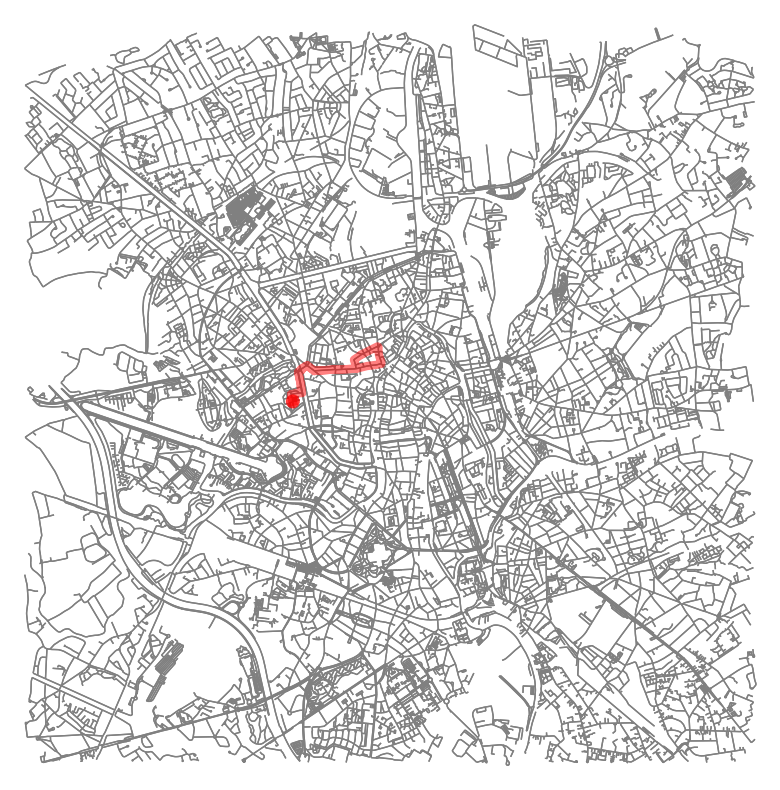

In [137]:
# Validate nodes and edges in the best_route
print("Validating nodes and edges in the best_route...")
validate_nodes(graph, best_route_SA)
validate_edges(graph, best_route_SA)

# Build a fully valid route
valid_route = build_valid_route(graph, best_route_SA)

if valid_route:
    print("Valid route constructed successfully.")
    print("Valid Route (Node IDs):", valid_route)
else:
    print("The route contains unreachable nodes. Please verify the graph and node connections.")

#### Brute Force

In [135]:
best_path_BF, best_length_BF, history_BF, best_lengths_BF = brute_force_algorithm(
    graph=graph, 
    nodes=nodes_to_visit, 
    start_node=start_node['UGent Campus Coupure'], 
    target_distance=target_distance, 
    allow_vertex_reuse=False, 
    threshold=6679, 
    verbose=1
)

print("Best Path:", best_path_BF)
print("Path Length:", best_length_BF)

Generation 0: Path [8681159626, 599296037, 1128900973, 82778718, 8681159626] | Length = 3106.54
Generation 1: Path [8681159626, 599296037, 82778718, 1128900973, 8681159626] | Length = 3321.64
Generation 2: Path [8681159626, 1128900973, 599296037, 82778718, 8681159626] | Length = 3257.83
Generation 3: Path [8681159626, 1128900973, 82778718, 599296037, 8681159626] | Length = 3321.64
Generation 4: Path [8681159626, 82778718, 599296037, 1128900973, 8681159626] | Length = 3257.83
Generation 5: Path [8681159626, 82778718, 1128900973, 599296037, 8681159626] | Length = 3106.54
Best Path: [8681159626, 599296037, 82778718, 1128900973, 8681159626]
Path Length: 3321.640717046029


In [155]:
def plot_routes(graph, routes, route_labels=None):
    """
    Plots multiple routes on a graph for comparison.

    Parameters:
    - graph: The NetworkX graph.
    - routes: List of routes (each route is a list of node IDs).
    - route_labels: Optional list of labels for each route.
    """
    if route_labels is None:
        route_labels = [f"Route {i+1}" for i in range(len(routes))]

    # Plot the base graph
    fig, ax = ox.plot_graph(graph, show=False, close=False, bgcolor="white", edge_color="lightgray", node_color="lightgray", node_size=1)

    # Define colors for the routes
    colors = ["red", "blue", "green"]
    styles = ["-", "-", "-"]

    # Plot each route with a different color and style
    for i, route in enumerate(routes):
        edges = []
        for j in range(len(route) - 1):
            subroute = nx.shortest_path(graph, route[j], route[j + 1], weight="length")
            edges += list(zip(subroute[:-1], subroute[1:]))

        edge_positions = [
            (graph.nodes[u]["x"], graph.nodes[u]["y"], graph.nodes[v]["x"], graph.nodes[v]["y"])
            for u, v in edges
        ]

        for x1, y1, x2, y2 in edge_positions:
            ax.plot([x1, x2], [y1, y2], color=colors[i % len(colors)], linestyle=styles[i % len(styles)], linewidth=2, label=route_labels[i] if j == 0 else "")

    # Add a legend
    ax.legend(route_labels, loc="lower left")
    plt.title("Comparison of Routes Through the Graph")
    plt.show()


In [156]:
def plot_routes_separately(graph, routes, route_labels=None):
    """
    Plots each route separately on the graph.

    Parameters:
    - graph: The NetworkX graph.
    - routes: List of routes (each route is a list of node IDs).
    - route_labels: Optional list of labels for each route.
    """
    if route_labels is None:
        route_labels = [f"Route {i+1}" for i in range(len(routes))]

    # Set up subplots
    fig, axes = plt.subplots(1, len(routes), figsize=(18, 6))
    if len(routes) == 1:  # If there's only one route, axes is not iterable
        axes = [axes]

    # Colors for routes
    colors = ["red", "blue", "green"]

    for i, (route, ax) in enumerate(zip(routes, axes)):
        # Plot the base graph on each subplot
        ox.plot_graph(graph, ax=ax, show=False, close=False, bgcolor="white", edge_color="lightgray", node_color="lightgray", node_size=1)

        # Extract edges for the route
        edges = []
        for j in range(len(route) - 1):
            subroute = nx.shortest_path(graph, route[j], route[j + 1], weight="length")
            edges += list(zip(subroute[:-1], subroute[1:]))

        # Plot the edges for the route
        edge_positions = [
            (graph.nodes[u]["x"], graph.nodes[u]["y"], graph.nodes[v]["x"], graph.nodes[v]["y"])
            for u, v in edges
        ]
        for x1, y1, x2, y2 in edge_positions:
            ax.plot([x1, x2], [y1, y2], color=colors[i % len(colors)], linewidth=2)

        # Add title for each subplot
        ax.set_title(route_labels[i])

    plt.tight_layout()
    plt.show()


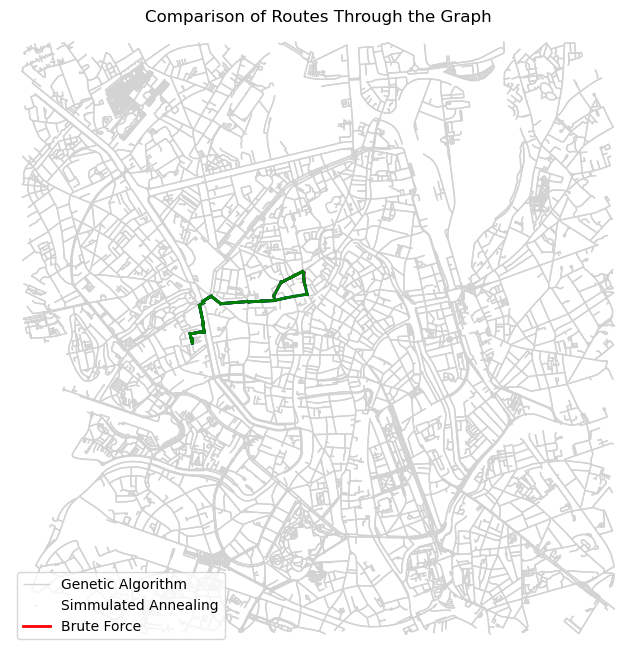

In [157]:
plot_routes(graph, [best_path_GA, valid_route, best_path_BF], route_labels=["Genetic Algorithm", "Simmulated Annealing", "Brute Force"])

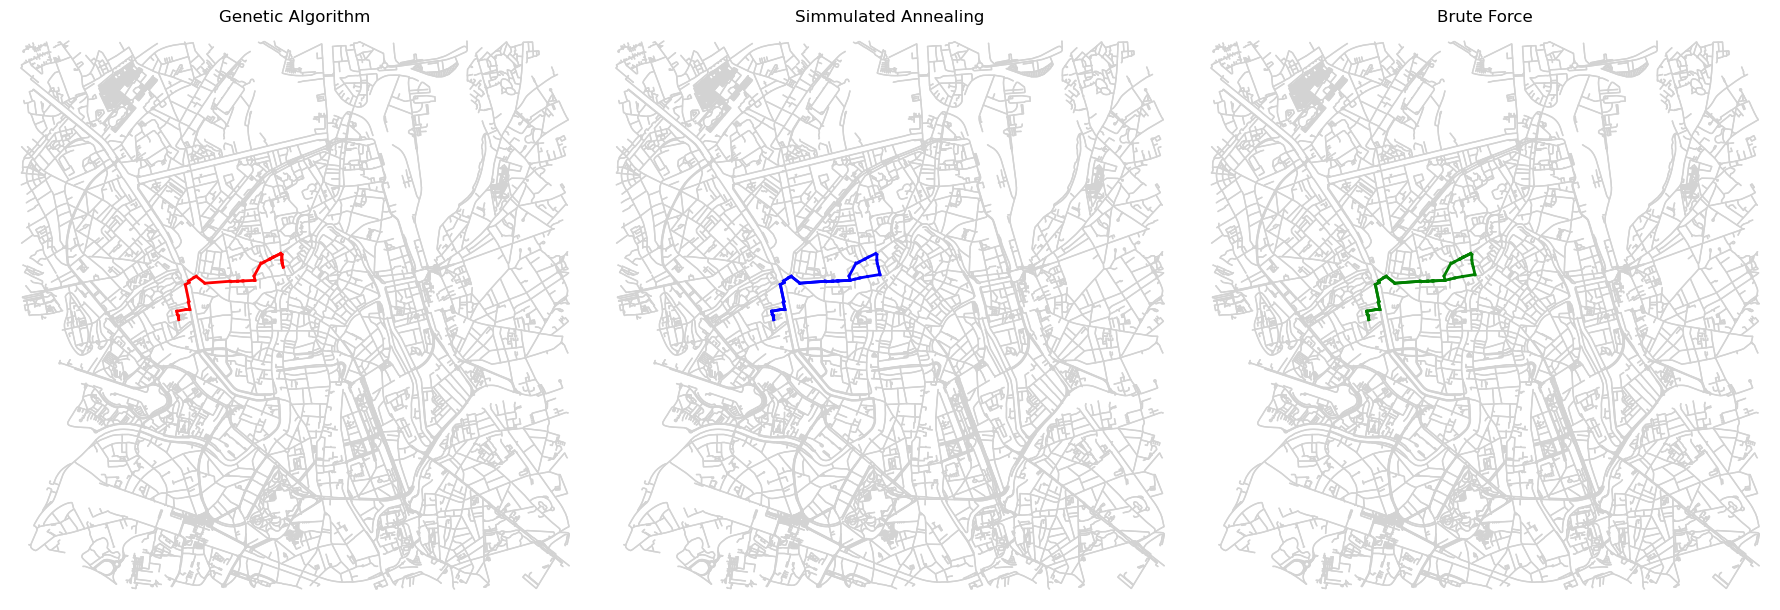

In [158]:
plot_routes_separately(graph, [best_path_GA, valid_route, best_path_BF], route_labels=["Genetic Algorithm", "Simmulated Annealing", "Brute Force"])

## Adding more stops

In [159]:
points_of_interest = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Museum of Industry": "Minnemeers 10, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium",
    "St. Bavo's Cathedral": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Ghent University Botanical Garden": "Karel Lodewijk Ledeganckstraat 35, 9000 Gent, Belgium",
    "STAM Ghent City Museum": "Godshuizenlaan 2, 9000 Gent, Belgium",
    "Design Museum Gent": "Jan Breydelstraat 5, 9000 Gent, Belgium" 
}

nodes_to_visit = {}
for monument in points_of_interest.keys():
    current = addresses[monument]
    nodes_to_visit[monument] = translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

Nodes dict: {'Gravensteen': 599296037, 'Museum of Industry': 4580267383, 'Sint Rita': 1128900973, 'Lievekaai': 82778718, "St. Bavo's Cathedral": 498848408, 'Ghent University Botanical Garden': 10962332866, 'STAM Ghent City Museum': 26268461, 'Design Museum Gent': 1212148854}


In [160]:
best_path_GA, best_length_GA, history_GA, best_lengths_GA = genetic_algorithm(
    graph = graph, 
    nodes = nodes_to_visit, 
    start_node = start_node, 
    target_distance = target_distance, 
    generations = 100, population_size=100, 
    mutation_rate=0.5, early_stopping_rounds=15,
    allow_vertex_reuse=False
)
print("Best Path:", best_path_GA)
print("Path Length:", best_length_GA)

Generation: [1/100] --- Best length: 9999.10598637718
Generation: [2/100] --- Best length: 9999.10598637718
Generation: [3/100] --- Best length: 9999.10598637718
Generation: [4/100] --- Best length: 9999.10598637718
Generation: [5/100] --- Best length: 9999.10598637718
Generation: [6/100] --- Best length: 9999.10598637718
Generation: [7/100] --- Best length: 9999.10598637718
Generation: [8/100] --- Best length: 9999.10598637718
Generation: [9/100] --- Best length: 9999.10598637718
Generation: [10/100] --- Best length: 9999.10598637718
Generation: [11/100] --- Best length: 10000.361062348795
Generation: [12/100] --- Best length: 10000.361062348795
Generation: [13/100] --- Best length: 10000.361062348795
Generation: [14/100] --- Best length: 10000.361062348795
Generation: [15/100] --- Best length: 10000.361062348795
Generation: [16/100] --- Best length: 10000.361062348795
Generation: [17/100] --- Best length: 10000.361062348795
Generation: [18/100] --- Best length: 10000.361062348795
Gen

In [161]:
best_route_SA, best_distance_SA = simulated_annealing(
    graph, list(nodes_to_visit.values()), start_node['UGent Campus Coupure'], max_iterations=1000, initial_temp=1000, cooling_rate=0.99
)
print("Best Route (Node IDs):", best_route_SA)
print("Best Distance (meters):", best_distance_SA)

Best Route (Node IDs): [8681159626, 1212148854, 82778718, 1128900973, 599296037, 4580267383, 498848408, 10962332866, 26268461, 8681159626]
Best Distance (meters): 8511.742856726627


In [162]:
# Validate nodes and edges in the best_route
print("Validating nodes and edges in the best_route...")
validate_nodes(graph, best_route_SA)
validate_edges(graph, best_route_SA)

# Build a fully valid route
valid_route = build_valid_route(graph, best_route_SA)

if valid_route:
    print("Valid route constructed successfully.")
    print("Valid Route (Node IDs):", valid_route)
else:
    print("The route contains unreachable nodes. Please verify the graph and node connections.")

Validating nodes and edges in the best_route...
All nodes in the route exist in the graph.
Missing edges between consecutive nodes: [(8681159626, 1212148854), (1212148854, 82778718), (82778718, 1128900973), (1128900973, 599296037), (599296037, 4580267383), (4580267383, 498848408), (498848408, 10962332866), (10962332866, 26268461), (26268461, 8681159626)]
Valid route constructed successfully.
Valid Route (Node IDs): [8681159626, 8681159627, 8681159629, 8122088729, 8681159630, 662373074, 662373164, 662373263, 662373279, 588005550, 1503969201, 1503969125, 1503969222, 96167070, 279878853, 279878854, 247878877, 82775039, 2229540762, 592615330, 8162261651, 6632039674, 82775038, 6632039673, 82775029, 506198656, 82775033, 10941916523, 82775035, 1212148854, 82775035, 82777158, 82780136, 82778718, 283170741, 1128900973, 1128900991, 599296046, 599296047, 599296037, 599296032, 599296036, 599296038, 280547739, 599296070, 280547736, 599296061, 283170724, 599296071, 510815805, 1131144713, 567182028, 

In [1]:
best_path_BF, best_length_BF, history_BF, best_lengths_BF = brute_force_algorithm(
    graph=graph, 
    nodes=nodes_to_visit, 
    start_node=start_node['UGent Campus Coupure'], 
    target_distance=target_distance, 
    allow_vertex_reuse=False, 
    threshold=6679, 
    verbose=1
)

print("Best Path:", best_path_BF)
print("Path Length:", best_length_BF)

NameError: name 'brute_force_algorithm' is not defined

In [ ]:
plot_routes(graph, [best_path_GA, valid_route, best_path_BF], route_labels=["Genetic Algorithm", "Simmulated Annealing", "Brute Force"])

In [ ]:
plot_routes_separately(graph, [best_path_GA, valid_route, best_path_BF], route_labels=["Genetic Algorithm", "Simmulated Annealing", "Brute Force"])